# Supervised Learning Classification

This notebook compares multiple classifiers with PCA preprocessing.

In [1]:

import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

X, y = load_wine(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42))
])
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)]
)


In [3]:

dummy = Pipeline(steps=[('preprocessor', preprocessor), ('model', DummyClassifier(strategy='most_frequent'))])
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision_macro': precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)[0],
    'recall_macro': precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)[1],
    'f1_macro': precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)[2]
}
baseline_metrics


{'accuracy': 0.3888888888888889,
 'precision_macro': 0.12962962962962962,
 'recall_macro': 0.3333333333333333,
 'f1_macro': 0.18666666666666668}

In [4]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, multi_class='auto', random_state=42),
    'SVC': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    res = {'model': name}
    res['cv_accuracy'] = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy').mean()
    res['cv_f1_macro'] = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro').mean()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)
    res['test_accuracy'] = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
    res['test_precision_macro'] = precision
    res['test_recall_macro'] = recall
    res['test_f1_macro'] = f1
    res['test_precision_weighted'], res['test_recall_weighted'], res['test_f1_weighted'], _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    res['test_roc_auc_ovr'] = roc_auc_score(y_test, y_prob, multi_class='ovr')
    results.append(res)
results_df = pd.DataFrame(results)
results_df


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_logisti

,model,cv_accuracy,cv_f1_macro,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc_ovr
0,LogisticRegression,0.965271,0.965853,0.972222,0.977778,0.966667,0.970962,0.974074,0.972222,0.971970,1.000000
1,SVC,0.986207,0.986482,0.972222,0.977778,0.966667,0.970962,0.974074,0.972222,0.971970,1.000000
2,KNN,0.943842,0.945175,0.972222,0.969697,0.976190,0.971781,0.974747,0.972222,0.972369,0.998818
3,DecisionTree,0.944089,0.946530,0.944444,0.948413,0.948413,0.948413,0.944444,0.944444,0.944444,0.959686
4,RandomForest,0.971921,0.972239,0.944444,0.948413,0.948413,0.948413,0.944444,0.944444,0.944444,0.997760
5,GradientBoosting,0.929557,0.931536,0.888889,0.909722,0.881746,0.890741,0.899306,0.888889,0.889506,0.918106


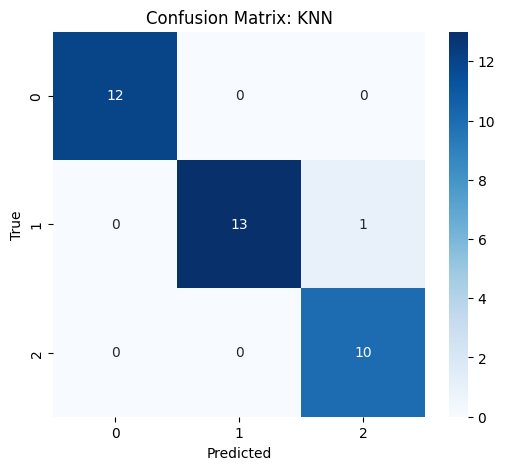

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.93      0.96        14
           2       0.91      1.00      0.95        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



In [5]:

best_model_name = results_df.sort_values('test_f1_macro', ascending=False).iloc[0]['model']
best_model = models[best_model_name]
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()
print(classification_report(y_test, y_pred))


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


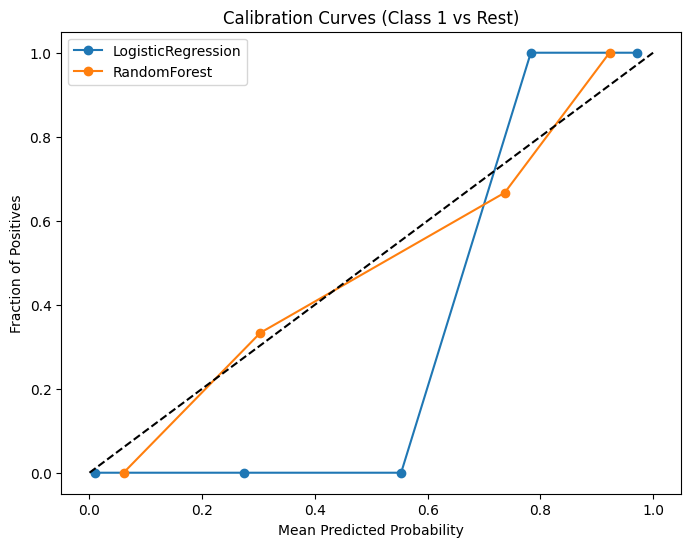

In [6]:

plt.figure(figsize=(8,6))
y_true_binary = (y_test == 1).astype(int)
for name in ['LogisticRegression', 'RandomForest']:
    model = models[name]
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    prob_pos = pipe.predict_proba(X_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_true_binary, prob_pos, n_bins=5)
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves (Class 1 vs Rest)')
plt.legend()
plt.show()


In [7]:

results_df.sort_values('test_f1_macro', ascending=False)


,model,cv_accuracy,cv_f1_macro,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc_ovr
2,KNN,0.943842,0.945175,0.972222,0.969697,0.976190,0.971781,0.974747,0.972222,0.972369,0.998818
0,LogisticRegression,0.965271,0.965853,0.972222,0.977778,0.966667,0.970962,0.974074,0.972222,0.971970,1.000000
1,SVC,0.986207,0.986482,0.972222,0.977778,0.966667,0.970962,0.974074,0.972222,0.971970,1.000000
3,DecisionTree,0.944089,0.946530,0.944444,0.948413,0.948413,0.948413,0.944444,0.944444,0.944444,0.959686
4,RandomForest,0.971921,0.972239,0.944444,0.948413,0.948413,0.948413,0.944444,0.944444,0.944444,0.997760
5,GradientBoosting,0.929557,0.931536,0.888889,0.909722,0.881746,0.890741,0.899306,0.888889,0.889506,0.918106
